In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import eddytools as et
from cmocean import cm
from scipy.signal import convolve
import os
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

sigma = 9 # smoothing parameter

In [3]:
# paths

#'/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/' + output or suppl
datapath = f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'                  ## !! SMOOTHED !!
meshpath = ['/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/OW-prep/2_INALT60.L120-KRS0020_mesh_mask.nc']

In [4]:
datestart, dateend = "2012-04-10", "2012-05-04"
#periods = [
#    #("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"), ("2012-03-16", "2012-04-09"),
#    ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [5]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset(meshpath[0]) 
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in range(0, 91, 3)] #upper 3000m, otherwise: range(0, len(mesh_mask.nav_lev.values), 3), every 3rd value
print(depth_information)

[(0, 0), (4, 3), (10, 6), (18, 9), (27, 12), (39, 15), (54, 18), (71, 21), (91, 24), (114, 27), (141, 30), (173, 33), (210, 36), (253, 39), (304, 42), (365, 45), (437, 48), (525, 51), (629, 54), (753, 57), (899, 60), (1066, 63), (1254, 66), (1461, 69), (1684, 72), (1922, 75), (2170, 78), (2428, 81), (2692, 84), (2963, 87), (3238, 90)]


In [6]:
# Define the parameters for the interpolation
interpolation_parameters = {'model': 'ORCA',
                            'grid': 'latlon',
                            'calendar': 'standard', # calendar, must be either 360_day or standard
                            'lon1': 0, # minimum longitude of detection region
                            'lon2': 40, # maximum longitude
                            'lat1': -45, # minimum latitude
                            'lat2': -25, # maximum latitude
                            'res': 1./60., # resolution of the fields in degrees
                            'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated #, 'votemper', 'vosaline'
                            'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry'], # masks to interpolate
                            'regrid_method': 'bilinear', # method used for regridding (default is 'bilinear')
                            'ext_method': None} 

In [7]:
def nanconv(a, k, MODE):
    # Flat function for comparison.
    o = np.ones(np.shape(a))
    # Flat function with NaNs for comparison.
    on = np.ones(np.shape(a))
    # Find all the NaNs in the input and replace with 0
    an = np.where(~np.isnan(a), a, 0)
    on = np.where(~np.isnan(a), on, 0)
    # Calculate what a 'flat' function looks like after convolution.
    flat = convolve(on, k, mode=MODE)
    #
    # The line above will automatically include a correction for edge 
    # effects,
    # so remove that correction if the user does not want it.
    flat = flat / convolve(o, k, mode=MODE)
    #
    # Do the actual convolution
    output = convolve(an, k, mode=MODE) / flat
    return np.where(~np.isnan(a), output, np.nan)

def spatial_std(data, wx, wy):
    window = np.ones((1, wy, wx)) / (wy * wx)
    ext = np.zeros((np.shape(data)[0], 
                    np.shape(data)[1] + wy, np.shape(data)[2] + wx))
    ext[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)] = data
    ext[:, 0:int(wy/2), :] = ext[:, int(wy):int(wy/2):-1, :]
    ext[:, -int(wy/2)::, :] = ext[:, -int(wy/2):-int(wy):-1, :]
    ext[:, :, 0:int(wx/2)] = ext[:, :, int(wx):int(wx/2):-1]
    ext[:, :, -int(wx/2)::] = ext[:, :, -int(wx/2):-int(wx):-1]
    std_tmp1 = np.abs(ext - nanconv(ext, window, "same")) ** 2
    std_tmp2 = nanconv(std_tmp1, window, "same") ** 0.5
    output =  xr.DataArray(std_tmp2[:, int(wy/2):-int(wy/2), int(wx/2):-int(wx/2)], 
                           coords=data.coords, dims=data.dims).mean("time") 
    return output

In [8]:
#for (datestart, dateend) in tqdm(periods):
#    print(f"> Starting: {datestart.replace("-", "")}-{dateend.replace("-", "")} ...")
for (depth, depth_index) in tqdm(depth_information):
    print(f"> Starting: {datestart.replace('-', '')}, {depth}m ...")
    interpolation_parameters['start_time'], interpolation_parameters['end_time'] = datestart, dateend
    filename_pattern = f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_[UV].nc' ## !! SMOOTHED !!
    data_in = sorted(glob(datapath + filename_pattern))
    outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!
    os.makedirs(outpath, exist_ok=True)
    output_file = os.path.join(outpath, f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}.nc')
    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Skipping...")
        continue

    data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
                          input_ds_chunks = {"time_counter": 1, "depthu": 1, "depthv": 1, "depthw": 1, "t": 1, "z": 120, "x": 2404, "y": 1483},
                          target_ds_chunks = {"t": 1, "z_c": 1, "z_l": 1, "x_c": 2404, "x_r": 2404, "y_c": 1483, "y_r": 1483},
                          decode_cf=True,   
                         )
    
    # define metrics for xgcm (not strictly necessary)
    at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
    av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
    vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

    data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
    data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

    metrics = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
        ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
    }

    # add bathymetry to data to have depth information
    bathy = xr.open_mfdataset('/gxfs_work/geomar/smomw523/inalt60/data/INALT60.L120-KRS0020/2_INALT60.L120-KRS0020_bathy.nc')
    data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['bathymetry'].data)})

    grid = xgcm.Grid(data, metrics=metrics)

    # Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
    data_OW = et.okuboweiss.calc(data.isel(z_c=depth_index, z_l=depth_index), grid, #surface
                                'vozocrtx', 'vomecrty').chunk({'x_c': 2404, 'x_r': 2404,
                                                                'y_c': 1483, 'y_r': 1483})
    # Merge the new variables `OW` and `vort` to the dataset `data`
    data = xr.merge([data, data_OW], compat='override')
    # Interpolate
    data_int, regridder = et.interp.horizontal(data, metrics, interpolation_parameters, weights=None, avoid_regrid=False)

    OW_tmp = data_int['OW'].compute()
    OW_tmp = OW_tmp.where(OW_tmp != 0)
    lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
    OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})
    wx = 100 # rolling window size in x-direction
    wy = 100 # rolling window size in y-direction
    mean_OW_spatial_std = spatial_std(OW_tmp, wx, wy)
    # use if OW_std is 2D
    data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

     # Store the interpolated field on disk so we do not have to do the interpolation again
    data_int.to_netcdf(output_file)


  0%|          | 0/31 [00:00<?, ?it/s]

Starting: 20120410, 0m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-0/OW_20120410_20120504.nc already exists. Skipping...
Starting: 20120410, 4m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-4/OW_20120410_20120504.nc already exists. Skipping...
Starting: 20120410, 10m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-10/OW_20120410_20120504.nc already exists. Skipping...
Starting: 20120410, 18m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-18/OW_20120410_20120504.nc already exists. Skipping...
Starting: 20120410, 27m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-27/OW_20120410_20120504.nc already exists. Skipping...
Starting: 20120410, 39m ...
File /gxfs_work/geomar/smomw523/eddytools/results/INALT60.L120-KRS0020/smoothed/9/1d/depth-39/OW_20120410_

 90%|█████████ | 28/31 [02:04<00:13,  4.45s/it]

Starting: 20120410, 2692m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 94%|█████████▎| 29/31 [03:50<00:18,  9.37s/it]

Starting: 20120410, 2963m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


 97%|█████████▋| 30/31 [05:46<00:16, 16.27s/it]

Starting: 20120410, 3238m ...
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating OW
Interpolating vort
Interpolating fmask
Interpolating tmask
Interpolating bathymetry
Interpolating e1f
Interpolating e2f


100%|██████████| 31/31 [07:42<00:00, 14.92s/it]


### Visualisation

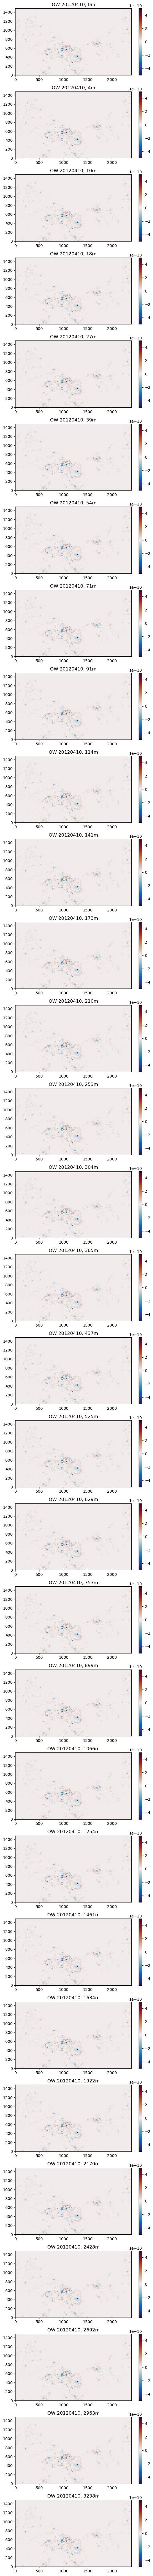

In [9]:
#fig, axes = plt.subplots(len(periods), 1, figsize=(10, 5 * len(periods))) 
#for ax, (datestart, dateend) in zip(axes, periods):
fig, axes = plt.subplots(len(depth_information), 1, figsize=(6, 3 * len(depth_information))) 
for ax, (depth, depth_index) in zip(axes, depth_information):
    data_int = xr.open_dataset(outpath + f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}.nc')
    im = ax.pcolormesh(data_int['OW'].isel(time=0), vmin=-5e-10, vmax=5e-10, cmap=cm.balance)
    ax.set_title(f'OW {datestart.replace("-", "")}, {depth}m')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

We see several eddy-like features that have a low OW-parameter, now let's see whether the algorithm detects them as eddies!